# Sentiment Analysis on IMDb reviews using BiLSTM and ELECTRA
Author: Tiberiu Rociu  
Student ID: 2006061  
<small>*Total word count: 900 words*</small>

# I. Introduction
<small>*Section word count: 141 words*</small>

The IMDb dataset is a collection of 50,000 movie reviews, structured as a collection of text and label pairs. The dataset is popular for binary sentiment analysis in machine learning papers (TODO INSERT REFERENCES).

The task performed in this coursework is a binary sentiment classification, with the goal of predicting if a review is positive or negative, when analysing the review's textual contents that is being passed as input. As the name implies, there are only two labels for this dataset, `0` for negative, and `1` for positive.

To accomplish this task, two NLP models will be used, BiLSTM and ELECTRA. An NLP model architecture is needed for this task, as the review semantics need to be understood in order to asses the sentiment behind it. Simpler machine learning models like Random Forest or Support Vector Machine won't be able to capture this nuances. 

# II. Representation Learning

<small>*Section word count: 267 words*</small>

There are two methods used in this coursework for converting the textual data into a numerical vector, each to fit the exepected format of the model they will be used on.

The first method involves running the reviews through a custom pre-processing function that will remove numbers, tokenize the text using RegexpTokenizer, normalising the text, removing stopwords using Nltk, and lastly, lemmantizing the tokens using WordNetLemmatizer. The next step of the vectorization pipeline, is running the tokens through as custom FastText vectorizer, where each token is matched with a key in the FastText dictionary and replaced with the vector representation of that word. Lastly for the FastText vectorization, the tokenized vectors will be padded to ensure dimension consistency and reshaped to a 3D representation, to match with the expected model input. 

The second method is simpler in terms of implementation and differs from the first one, as the ELECTRA model expects the vectorization to be performed by the ElectraTokenizer. This tokenizer will perform automatically the pre-processing and vectorization, so things like manual lemmantezation or stemming are not needed, since they might clash with the word dictionary that the ELECTRA tokenizer is using. Besides the vectorized tokens, the ElectraTokenizer will also return an attention mask, to explicitly tell the model which tokens are padding and which are words, to ensure the model focuses on the important words. 

Both vectorization methods have the length of 250 tokens, as this encompanses the length of 90% of the reviews in the dataset. Longer reviews will have to be truncated, because accomodating for all their size would drastically increase the training time. 





In [79]:
import pandas as pd

# Importing the training and testing datasets
dataset_splits = {'train': 'Dataset_IMDB_Sentiment/plain_text/train-00000-of-00001.parquet', 'test': 'Dataset_IMDB_Sentiment/plain_text/test-00000-of-00001.parquet'}
imdb_train_df = pd.read_parquet(dataset_splits["train"])
imdb_test_df = pd.read_parquet(dataset_splits['test'])

In [80]:
# Visualising the dataset 
print(imdb_train_df.head(5))
print(f"Row count: {len(imdb_train_df)}")

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
Row count: 25000


In [81]:
# Showing the amount of gaps for the train and test dataset
missing_values_train = imdb_train_df[['text', 'label']].isnull().sum().to_dict()
missing_values_test = imdb_test_df[['text', 'label']].isnull().sum().to_dict()
print(f"The train dataset has {missing_values_train['text']} missing reviews and {missing_values_train['label']} missing labels.")
print(f"The test dataset has {missing_values_test['text']} missing reviews and {missing_values_test['label']} missing labels.")

# Calculate review lengths
imdb_train_df['review_length'] = imdb_train_df['text'].apply(len)
imdb_test_df['review_length'] = imdb_test_df['text'].apply(len)

# Statistics for review lengths
def print_dataset_basic_statistics(df, dataset_name):
    # Caclulate the total word count for each review 
    df['review_length'] = df['text'].apply(lambda review: len(str(review).split()))
    print(f"\nStatistics for the {dataset_name} dataset:")
    print(f"\tAverage review word count: {df['review_length'].mean():.0f}")
    print(f"\tMinimum review word count: {df['review_length'].min()}")
    print(f"\tMaximum review word count: {df['review_length'].max()}")

print_dataset_basic_statistics(imdb_train_df, "train")
print_dataset_basic_statistics(imdb_test_df, "test")

The train dataset has 0 missing reviews and 0 missing labels.
The test dataset has 0 missing reviews and 0 missing labels.

Statistics for the train dataset:
	Average review word count: 234
	Minimum review word count: 10
	Maximum review word count: 2470

Statistics for the test dataset:
	Average review word count: 229
	Minimum review word count: 4
	Maximum review word count: 2278


In [82]:
import nltk

nltk.download('punkt') 
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tiberiu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tiberiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin # This allows the custom class to work with the Pipeline
from nltk.tokenize import word_tokenize, RegexpTokenizer # Import the tokenize package and regex tokenizer
from nltk.corpus import stopwords # Import stopwords for stopwords removal
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Import the snowball stemmer (also known as Porter2)
import re # Import regex
import numpy as np

class pre_process(BaseEstimator, TransformerMixin):
    def __init__(self):
      # Initialize objects for efficiency
      self.stemmer = SnowballStemmer("english")
      self.lemmatizer = WordNetLemmatizer()
      self.tokenizer = self.tokenizer = RegexpTokenizer(r'\w+')
      self.stopwords = stopwords.words("english")
      return None

    def fit(self, X, y=None):
        return self 

    def transform(self, X, y=None):
      processed_text = []
      for text in X:
        text = re.sub(r'\d+', '', text)  # Remove numbers
        token_text = self.tokenizer.tokenize(text) 
        normalised_text = [token.lower() for token in token_text if token.isalpha()]

        no_stopwords_text = [token for token in normalised_text if token not in self.stopwords]

        # Using lemmatization
        processed_text.append([self.lemmatizer.lemmatize(word) for word in no_stopwords_text]) # Applying the lemmatizer

      #  Return tokens as a list of words (this ensure compatibility with FastText)
      return processed_text

In [84]:
from keras.preprocessing.sequence import pad_sequences

# The FastText class
class FastTextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_path, max_sequence_length, vector_dimension):
        self.model_path = model_path
        self.max_sequence_length = max_sequence_length
        self.vector_dimension = vector_dimension
        self.word_vectors = self.load_fasttext_vectors()

    def load_fasttext_vectors(self):
        # Loading the FastText word vectors from the .vec file
        word_vectors = {}
        with open(self.model_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                word = parts[0]
                vector = np.array(parts[1:], dtype=np.float32)
                word_vectors[word] = vector
        return word_vectors

    def fit(self, X, y=None):
        return self

    def transform(self, tokens):
        # Convert each tokenized text into a list of word vectors
        tokenized_vectors = [
            [
                self.word_vectors[word] if word in self.word_vectors else np.zeros(self.vector_dimension)
                for word in token
            ]
            for token in tokens
        ]

        # Reshape data to 3D to make it compatible with the BiLSTM GRU model
        # Pad sequences to ensure consistent dimensions: sequence length, vector dim
        padded_data = pad_sequences(
            [np.array(seq) for seq in tokenized_vectors],
            maxlen = self.max_sequence_length,
            dtype = 'float32',
            padding = 'post',
            truncating = 'post',
        )

        return np.array(padded_data)

# III. Algorithms
<small>*Section word count: 381 words*</small>

## BiLSTM

The first model used, Bidirectional Long Short-Term Memory (BiLSTM), is a type of recurrent neural network (RNN) that improves on a unidirectional LSTM (Hochreiter and Schmidhuber, 1997), resulting in better context understanding. 

An RNN arhitecture allows the model to have some sort of memory, by preserving information between training loops, and allowing that information to impact the next training not just from the regular feed-forward. This still struggles with preserving information of long inputs, so the unidirectional LSTM was introduced and improved on the memory aspect by using an extra dimension in the form of the input gate, forget gate, and output gate (Siami-Namini, Tavakoli and Namin, 2019).

The BiLSTM uses two LSTM models, one traversing the input data from left to right, and another LSTM model going in reverse, from right to left (Islam, 2018). This ends up caturing the context dependencies from the past and future at the same time. 

In [85]:
# Showcasing the pre processing and vectorization outputs used in the final model training pipelines
from sklearn.pipeline import Pipeline # Adding the pipeline functionality

# Showcasing the pre-process pipeline output
pre_process_pipeline =  Pipeline([
  ('prep', pre_process()) # Custom pre-processing method
  ])

pre_process_example = pre_process_pipeline.fit_transform(imdb_train_df['text'][:1])
print(f"Below is an example of the pre-processed pipeline output:")
print(f"\tThe original text (as tokens): {imdb_train_df['text'][0]}")
print(f"\tThe pre-processed text: {pre_process_example[0]}")


Below is an example of the pre-processed pipeline output:
	The original text (as tokens): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this w

In [86]:
# Calculate the average tokens per imdb review. 
# This average will be used for the max sequence length in FastText, to avoid truncating and losing potential semantics information
pre_process_example = pre_process_pipeline.fit_transform(imdb_train_df['text'].values)

# Calculate token counts for each pre-processed text
token_lengths = [len(tokens) for tokens in pre_process_example]

# Calculate the statistics
average_tokens = sum(token_lengths) / len(token_lengths)
max_tokens = max(token_lengths)
min_tokens = min(token_lengths)
max_seq_len_90th  = int(np.percentile(token_lengths, 90))

print(f"Average number of tokens: {average_tokens:.0f}")
print(f"Maximum number of tokens: {max_tokens}")
print(f"Minimum number of tokens: {min_tokens}")
print(f"90th percentile token length: {max_seq_len_90th}")

Average number of tokens: 124
Maximum number of tokens: 1442
Minimum number of tokens: 4
90th percentile token length: 246


In [87]:
max_sequence_length = 250 # This is the 90th percentile review token length score (rounded)
vector_dimension = 300 # FastText vector dimension

# Showcasing the FastText vectorization pipeline output with 3D shaped data
fast_text_pipeline = Pipeline([
  ("prep", pre_process()), # Custom pre-processing method
  ("fast_text_vectorizer", FastTextVectorizer(
    model_path = "Libraries/FastText/wiki-news-300d-1M.vec",
    max_sequence_length = 250,
    vector_dimension = vector_dimension
    )), # FastText word to vector dictionary
  ])

fast_text_pipeline = fast_text_pipeline.fit_transform(imdb_train_df['text'][:1])
print(f"\tThe 3D reshaped data shape: {fast_text_pipeline.shape}")
print(f"\tThe 3D reshaped data representation (sample): {fast_text_pipeline[0][:10]}")

	The 3D reshaped data shape: (1, 250, 300)
	The 3D reshaped data representation (sample): [[ 0.1991  0.0065 -0.0965 ...  0.1122 -0.0166 -0.1085]
 [-0.1178 -0.1638  0.0755 ...  0.1817  0.2032  0.2252]
 [-0.049   0.032   0.024  ... -0.04    0.1997  0.0506]
 ...
 [ 0.0092 -0.0123 -0.0336 ...  0.1672 -0.0127  0.0247]
 [-0.0075 -0.0557 -0.0249 ...  0.0717  0.0584  0.0515]
 [-0.0764  0.0451 -0.0883 ...  0.1588  0.0052 -0.0104]]


In [124]:
# Adding the model wrapped in a custom Keras model to work with the Pipeline
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from keras import Input

class BiLSTM_GRU_Model(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, num_classes, dropout_rate):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.model = self.build_model()
    
    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Bidirectional(LSTM(32, return_sequences=True)))
        model.add(GRU(16))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(self.num_classes, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=16, verbose=1) # TODO CHANGE EPOCH TO 10 
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)

In [125]:
from sklearn.metrics import accuracy_score, classification_report

input_shape = (max_sequence_length, vector_dimension)  # Match the reshaped dimensions: max_sequence_length x vector_dimension

bilstm_gru_NLP_pipeline = Pipeline([
  ("prep", pre_process()), # Custom pre-processing method
  ("fast_text_vectorizer", FastTextVectorizer(
    model_path = "Libraries/FastText/wiki-news-300d-1M.vec",
    max_sequence_length = max_sequence_length,
    vector_dimension = vector_dimension
    )), # FastText word to vector dictionary
    ("model", BiLSTM_GRU_Model(input_shape = input_shape, num_classes = 1, dropout_rate = 0.3))  # BiLSTM GRU model
  ])

X_train = imdb_train_df['text'].values
y_train = imdb_train_df['label'].values

print(f"X_train length: {len(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train length: {len(y_train)}")
print(f"y_train shape: {y_train.shape}")

X_train length: 25000
X_train shape: (25000,)
y_train length: 25000
y_train shape: (25000,)


In [90]:
# Fit the BiLSTM pipeline
bilstm_gru_NLP_pipeline.fit(X_train, y_train)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 64ms/step - accuracy: 0.5160 - loss: 0.6917
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - accuracy: 0.5358 - loss: 0.6814
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - accuracy: 0.7524 - loss: 0.5125
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - accuracy: 0.8683 - loss: 0.3233
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - accuracy: 0.8855 - loss: 0.2832
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 64ms/step - accuracy: 0.8970 - loss: 0.2600
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - accuracy: 0.9052 - loss: 0.2429
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - accuracy: 0.9130 - loss: 0.2258
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.9224 - loss: 0.2085
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - accuracy: 0.9325 - loss: 0.1791


Pipeline(steps=[('prep', pre_process()),
                ('fast_text_vectorizer',
                 FastTextVectorizer(max_sequence_length=250,
                                    model_path='Libraries/FastText/wiki-news-300d-1M.vec',
                                    vector_dimension=300)),
                ('model',
                 BiLSTM_GRU_Model(dropout_rate=0.3, input_shape=(250, 300),
                                  num_classes=1))])

## ELECTRA

The second model used, Efficiently Learning an Encoder that Classifies Token Replacements Accurately (ELECTRA), is a pre-trained model that improves on the popular Masked Language Modelling (MLM) technique used by BERT (Clark et al., 2020). Instead of BERT's method, of masking certain tokens and training a model to predict what the original tokens would have been, ELECTRA uses a technique inspired by Generative Adversarial Networks (GAN) instead. These models are not in direct competition like GAN, since they are trained sequentially, and only the discriminator is retained for downstream tasks. The generator model will replace certain real tokens with tokens that would be probable in that context, and the discriminative model will attempt to identify which are the replaced tokens and which are the original from that given input. This approach outperforms other MLM methods such as BERT because the model utilizes the entire input during training, not just the smaller subset of masked tokens. 

The general ELECTRA model trained on a large vocabulary that includes Wikipedia, BooksCorpus, and other web-based datasets like CommonCrawl, can be further fine-tuned by training it on the dataset that predictions will be made on, adding this way even more domain knowledge to the model. There are many considerations for this last step of getting a custom ELECTRA model, as choosing the wrong training parameters, like training epochs, learning rate, warmup steps, and weight decay, can result in a model that overfits the data and doesn't generalize too well. 

In [94]:
import pandas as pd
from datasets import Dataset
from transformers import ElectraTokenizer, ElectraForSequenceClassification, TrainingArguments, Trainer

# Transforming into HuggingFace Dataset objects
imdb_train_hf = Dataset.from_pandas(imdb_train_df[['text', 'label']])
imdb_test_hf = Dataset.from_pandas(imdb_test_df[['text', 'label']])

# Loading the Electra tokeniser to use for the Electra model
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator', do_lower_case = True)

In [97]:
# Electra tokenising function
def electra_tokenize_function(data):
    return electra_tokenizer(data['text'], padding = "max_length", truncation = True, return_attention_mask = True, max_length = 512)

In [98]:
# Tokenising the dataset
imdb_train_hf = imdb_train_hf.map(electra_tokenize_function, batched = True)
imdb_test_hf = imdb_test_hf.map(electra_tokenize_function, batched = True)

Map: 100%|██████████| 25000/25000 [00:46<00:00, 535.86 examples/s]


In [100]:
# Loading the Electra model and setting the training parameters
electra_model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)

electra_training_arguments = TrainingArguments(
    output_dir = './results',  
    eval_strategy = "epoch", 
    learning_rate = 2e-5,  
    per_device_train_batch_size = 32, # Making the model use the GPU for training
    per_device_eval_batch_size = 32, 
    num_train_epochs = 7,
    weight_decay = 0.01, 
    warmup_steps = 200,
    logging_dir = './logs',
    logging_steps = 500,
    save_steps = 500,
    do_train = True,
    do_eval = True,
    fp16 = True
)

electra_trainer = Trainer(
    model = electra_model,
    args = electra_training_arguments,
    train_dataset = imdb_train_hf,
    eval_dataset = imdb_test_hf,
    processing_class = electra_tokenizer
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
import torch 

# Making sure the script recognizes the GPU, to ensure the model is in fact training on it
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))

Is CUDA available: True
GPU Device Name: NVIDIA GeForce RTX 3080


In [132]:
# Train the Electra model to fine tune it to the IMDB dataset
# NOTE FOR MARKING PURPOSES: Below this code block there will be code that will load the trained model already.
# Retraining the model will probably take a long time if a dedicated GPU is not used.
electra_trainer.train()

  9%|▉         | 500/5474 [01:01<09:47,  8.46it/s]

{'loss': 0.4595, 'grad_norm': 8.129602432250977, 'learning_rate': 1.8866135760333716e-05, 'epoch': 0.64}


 14%|█▍        | 783/5474 [02:10<10:50:44,  8.32s/it]

{'eval_loss': 0.22111102938652039, 'eval_runtime': 35.6266, 'eval_samples_per_second': 701.723, 'eval_steps_per_second': 21.95, 'epoch': 1.0}


 18%|█▊        | 1000/5474 [02:36<08:47,  8.48it/s]  

{'loss': 0.2467, 'grad_norm': 3.4743406772613525, 'learning_rate': 1.697004171406902e-05, 'epoch': 1.28}


 27%|██▋       | 1500/5474 [03:35<07:48,  8.49it/s]

{'loss': 0.2097, 'grad_norm': 7.339658260345459, 'learning_rate': 1.5073947667804325e-05, 'epoch': 1.92}


 29%|██▊       | 1565/5474 [04:19<9:10:34,  8.45s/it]

{'eval_loss': 0.2104008048772812, 'eval_runtime': 36.1802, 'eval_samples_per_second': 690.986, 'eval_steps_per_second': 21.614, 'epoch': 2.0}


 37%|███▋      | 2000/5474 [05:11<06:59,  8.28it/s]  

{'loss': 0.1768, 'grad_norm': 10.491612434387207, 'learning_rate': 1.3181645809632159e-05, 'epoch': 2.56}


 43%|████▎     | 2347/5474 [06:28<7:08:43,  8.23s/it]

{'eval_loss': 0.21426326036453247, 'eval_runtime': 35.2065, 'eval_samples_per_second': 710.096, 'eval_steps_per_second': 22.212, 'epoch': 3.0}


 46%|████▌     | 2500/5474 [06:46<05:50,  8.49it/s]  

{'loss': 0.1644, 'grad_norm': 13.929616928100586, 'learning_rate': 1.1285551763367465e-05, 'epoch': 3.2}


 55%|█████▍    | 3000/5474 [07:45<04:51,  8.47it/s]

{'loss': 0.146, 'grad_norm': 10.455008506774902, 'learning_rate': 9.389457717102768e-06, 'epoch': 3.84}


 57%|█████▋    | 3129/5474 [08:37<5:32:02,  8.50s/it]

{'eval_loss': 0.23497650027275085, 'eval_runtime': 36.3339, 'eval_samples_per_second': 688.062, 'eval_steps_per_second': 21.523, 'epoch': 4.0}


 64%|██████▍   | 3500/5474 [09:23<03:57,  8.30it/s]  

{'loss': 0.1209, 'grad_norm': 7.093782424926758, 'learning_rate': 7.4933636708380746e-06, 'epoch': 4.48}


 71%|███████▏  | 3911/5474 [10:50<3:39:11,  8.41s/it]

{'eval_loss': 0.25843173265457153, 'eval_runtime': 36.0038, 'eval_samples_per_second': 694.372, 'eval_steps_per_second': 21.72, 'epoch': 5.0}


 73%|███████▎  | 4000/5474 [11:01<02:57,  8.31it/s]  

{'loss': 0.1235, 'grad_norm': 0.8267873525619507, 'learning_rate': 5.597269624573379e-06, 'epoch': 5.12}


 82%|████████▏ | 4500/5474 [12:02<02:06,  7.70it/s]

{'loss': 0.1028, 'grad_norm': 10.743684768676758, 'learning_rate': 3.704967766401214e-06, 'epoch': 5.75}


 86%|████████▌ | 4693/5474 [13:02<1:48:32,  8.34s/it]

{'eval_loss': 0.2751871943473816, 'eval_runtime': 35.6822, 'eval_samples_per_second': 700.629, 'eval_steps_per_second': 21.916, 'epoch': 6.0}


 91%|█████████▏| 5000/5474 [13:38<00:56,  8.46it/s]  

{'loss': 0.0995, 'grad_norm': 1.5822471380233765, 'learning_rate': 1.808873720136519e-06, 'epoch': 6.39}


100%|██████████| 5474/5474 [15:10<00:00,  6.01it/s]

{'eval_loss': 0.27479496598243713, 'eval_runtime': 35.0741, 'eval_samples_per_second': 712.777, 'eval_steps_per_second': 22.296, 'epoch': 7.0}
{'train_runtime': 910.0772, 'train_samples_per_second': 192.291, 'train_steps_per_second': 6.015, 'train_loss': 0.17694938082654937, 'epoch': 7.0}


TrainOutput(global_step=5474, training_loss=0.17694938082654937, metrics={'train_runtime': 910.0772, 'train_samples_per_second': 192.291, 'train_steps_per_second': 6.015, 'total_flos': 5148437145600000.0, 'train_loss': 0.17694938082654937, 'epoch': 7.0})

In [ ]:
# Saving the Electra model
# NOTE FOR MARKING PURPOSES: Running this code block without training the Electra model first
# will overwrite the actual model, resulting in inconsitent predictions. 
# Please run just the following code block that loads the trained Electra model, if 
# you don't have the time/hardware/patience to train the model again.
electra_model.save_pretrained('./electra_custom_trained_model')
electra_tokenizer.save_pretrained('./electra_custom_trained_model')

('./electra_custom_trained_model\\tokenizer_config.json',
 './electra_custom_trained_model\\special_tokens_map.json',
 './electra_custom_trained_model\\vocab.txt',
 './electra_custom_trained_model\\added_tokens.json')

In [111]:
# Loading the custom Electra model and tokenizer
electra_custom_model = ElectraForSequenceClassification.from_pretrained('./electra_custom_trained_model')
electra_custom_tokenizer = ElectraTokenizer.from_pretrained('./electra_custom_trained_model')

# Create a new Trainer instance with the custom model
custom_electra_trainer = Trainer(
    model = electra_custom_model,
    processing_class = electra_custom_tokenizer,
    args = electra_training_arguments,
    eval_dataset = imdb_test_hf
)


# IV. Evaluation
<small>*Section word count: 111 words*</small>

In [115]:
# Using the BiLSTM pipeline to make the predictions
X_test = imdb_test_df['text'].values
y_test = imdb_test_df['label'].values
bilstm_y_pred = bilstm_gru_NLP_pipeline.predict(X_test)

# Comparing the predictions with the actual values for BiLSTM
bilstm_accuracy = accuracy_score(y_test, bilstm_y_pred)
print(f"BiLSTM model accuracy on the test dataset: {bilstm_accuracy * 100:.2f}%")
print("\nBiLSTM Classification Report:")
print(classification_report(y_test, bilstm_y_pred, target_names = ['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
BiLSTM model accuracy on the test dataset: 88.12%

BiLSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88     12500
    Positive       0.86      0.91      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [112]:
# Evaluate the Electra model on the test dataset
electra_results = custom_electra_trainer.evaluate()
print("Electra evaluation results:", electra_results)

100%|██████████| 782/782 [00:36<00:00, 21.18it/s]

Electra evaluation results: {'eval_loss': 0.27479496598243713, 'eval_model_preparation_time': 0.002, 'eval_runtime': 36.9574, 'eval_samples_per_second': 676.454, 'eval_steps_per_second': 21.159}


In [164]:
# Generating the Electra predictions on the test dataset
def predict_with_trainer(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = predictions.predictions.argmax(axis=1)
    return preds, predictions.label_ids

electra_predictions, labels = predict_with_trainer(custom_electra_trainer, imdb_test_hf)

# Showing the model accuracy
electra_accuracy = accuracy_score(labels, electra_predictions)
print(f"Custom Electra model accuracy on the test dataset: {electra_accuracy * 100:.2f}%")

# Showing the classification report
electra_report = classification_report(labels, electra_predictions, target_names=['Negative', 'Positive'])
print("\nELECTRA classification Report:\n", electra_report)

100%|██████████| 782/782 [00:37<00:00, 20.82it/s]

Custom Electra model accuracy on the test dataset: 92.82%

ELECTRA classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.91      0.93     12500
    Positive       0.91      0.95      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



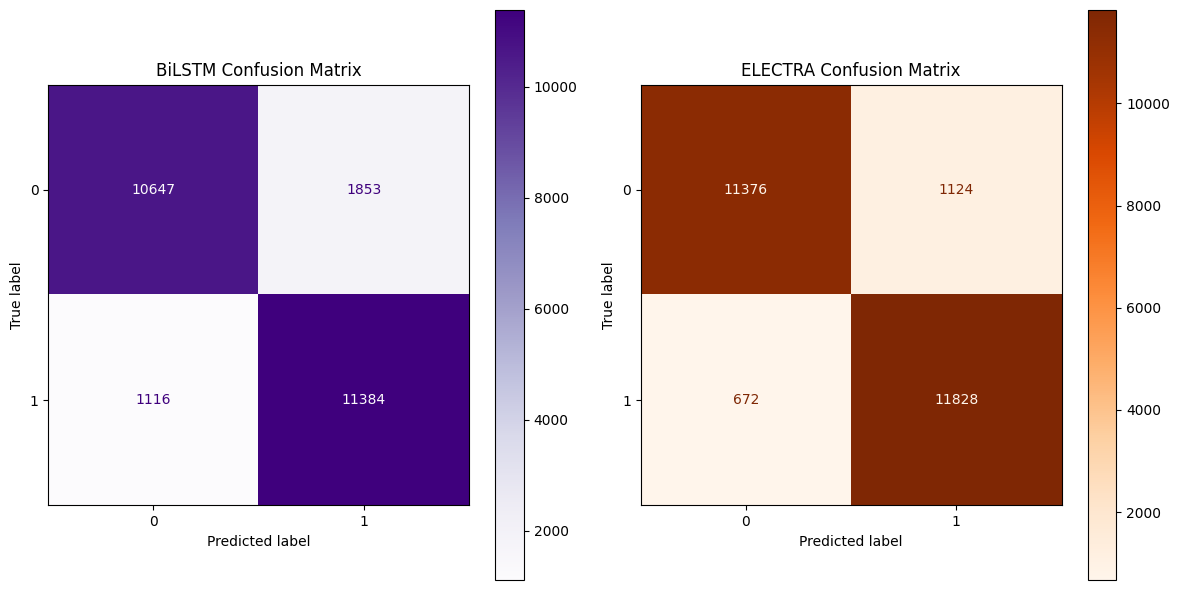

In [161]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrices for both models in a single figure
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
ConfusionMatrixDisplay.from_predictions(y_test, bilstm_y_pred, ax = axes[0], cmap = 'Purples')
axes[0].set_title("BiLSTM Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(labels, electra_predictions, ax = axes[1], cmap = 'Oranges')
axes[1].set_title("ELECTRA Confusion Matrix")
plt.tight_layout()
plt.show()


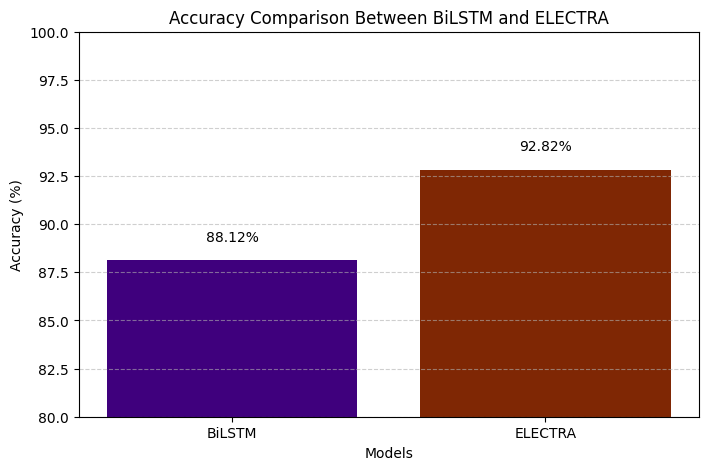

The Electra model is 4.69% more accurate than the BiLSTM model.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Accuracy values for both models
models = ['BiLSTM', 'ELECTRA']
accuracies = [bilstm_accuracy * 100, electra_accuracy * 100]

# Getting the same confusion matrix colours
bilstm_color = plt.get_cmap('Purples')(1.0)
electra_color = plt.get_cmap('Oranges')(1.0)

plt.figure(figsize = (8, 5))
plt.bar(models, accuracies, color = [bilstm_color, electra_color])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Between BiLSTM and ELECTRA')
plt.ylim(80, 100) # Showing only the 80% to 100% to better display the difference between the models
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adding accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha = 'center', fontsize = 10, color = 'black')
plt.show()

accuracy_difference = accuracies[1] - accuracies[0]
print(f"The Electra model is {accuracy_difference:.2f}% more accurate than the BiLSTM model.")

From the results shown, ELECTRA is clearly superior over BiLSTM, considering the already high accuracy percentages of both models, with a 4.69% higher accuracy. It is also outperforming in all classification metrics. With the 6% better recall for the negative reviews, ELECTRA is also the better option to reduce false negatives, especially for more critical domains such as medical diagnoses or legal documents. 

For this coursework, the small ELECTRA model with 14 million parameters was used due to potential hardware limitations. With two other available models, one with 110 million and an even larger one with 335 million parameters, the accuracy could potentially improve significantly if those models were used instead (GitHub, 2021).


# V. References

1. Hochreiter, S. and Schmidhuber, J. (1997) ‘Long Short-Term Memory’, Neural Computation, 9(8), pp. 1735–1780. Available at: https://doi.org/10.1162/neco.1997.9.8.1735.

2. Islam, M.S. (2018) A Deep Recurrent Neural Network with BiLSTM model for Sentiment Classification. Available at: https://www.researchgate.net/publication/328333982_A_Deep_Recurrent_Neural_Network_with_BiLSTM_model_for_Sentiment_Classification.

3. Siami-Namini, S., Tavakoli, N. and Namin, A.S. (2019) ‘The Performance of LSTM and BiLSTM in Forecasting Time Series’, 2019 IEEE International Conference on Big Data (Big Data), pp. 3285–3292. Available at: https://doi.org/10.1109/bigdata47090.2019.9005997.

4. Clark, K., Luong, M.-T., Le, Q.V. and Manning, C.D. (2020). ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.2003.10555.
‌
5. GitHub. (2021). google-research/electra. [online] Available at: https://github.com/google-research/electra.
‌